In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, utils
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, recall_score, accuracy_score
from skimage.measure import EllipseModel, find_contours
from skimage.draw import ellipse
import nibabel as nib
import SimpleITK as sitk
import numpy as np
import seaborn as sns
from scipy import ndimage, spatial, special
import scipy.optimize as optimize
import os
from radiomics import featureextractor
import radiomics
import numpy as np
import pandas as pd
import math
import datatable as dt
from skimage import io, transform
import seaborn as sns
import pickle
from torch.utils.data import DataLoader, Dataset
import glob
from PIL import Image
%matplotlib widget
import matplotlib.pyplot as plt

In [2]:
try:
    num_gpus = torch.cuda.device_count()
    print("Number of GPUs available:", num_gpus)
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
except Exception as e:
    print("Error while checking GPUs:", e)

Number of GPUs available: 3
GPU 0: NVIDIA RTX A6000
GPU 1: NVIDIA RTX A6000
GPU 2: NVIDIA RTX A6000


In [3]:
print(torch.cuda.is_available())

True


In [4]:
device = torch.device("cuda:1")

In [5]:
class AxialCutsDataset(Dataset):

    def __init__(self, data_shape, transform=None, for_trainning=False, mean=False, std=False, downsample=False):
        self.data = data_shape
        self.transform=transform
        self.for_trainning = for_trainning
        self.mean= mean
        self.std = std
        self.downsample = downsample

        if self.downsample:
            df_majority = self.data[self.data.iloc[:, 1]=='Irregular']
            df_majority_downsampled = resample(df_majority, replace=False, n_samples=1200, random_state=125)
            self.data = pd.concat((self.data[self.data['Shape'] != 'Irregular'], df_majority_downsampled))

    def __len__(self):
        return len(self.data.iloc[:, 0])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.data.iloc[idx, 0]
        image = io.imread(img_name)
        shape = self.data.iloc[idx, 1]
        sample = {'image': image, 'shape': shape}

        if self.transform:
            sample = self.transform(sample)

        return sample
        


In [6]:
def show_image(image):
    plt.imshow(image, vmin = 0, vmax = 255, cmap='grey')

0 (51, 51) Ambiguous
1 (51, 51) Ambiguous
2 (51, 51) Ambiguous
3 (51, 51) Ambiguous
4 (51, 51) Ambiguous
5 (51, 51) Ambiguous
6 (51, 51) Ambiguous


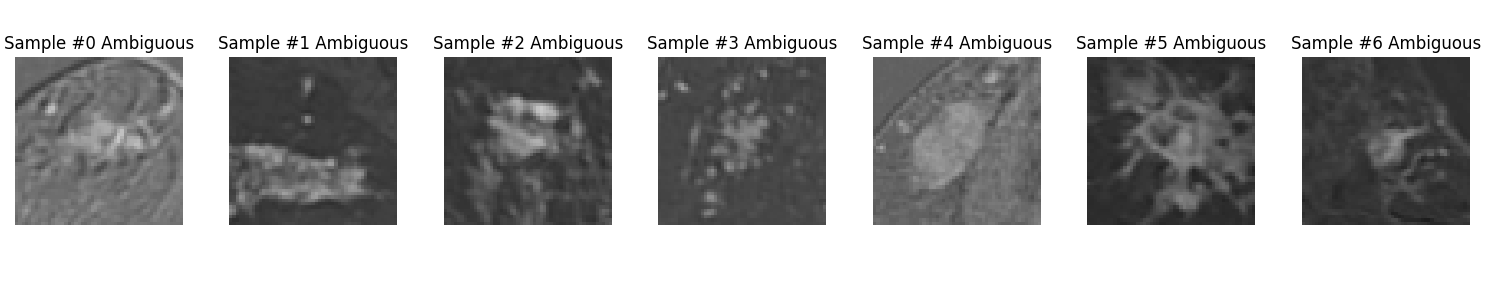

In [7]:
images_path = '/mnt/data/psteinmetz/neotex/data_CNN/images_15062024/'
data = pd.concat(
    (
        pd.DataFrame(glob.glob(f'{images_path}*/*png')),
        pd.DataFrame(
            [x.split('/')[-1][:-4] for x in glob.glob(f'{images_path}*/*png')]
        ),
        pd.DataFrame(
            [k.split('/')[-2] for k in glob.glob(f'{images_path}*/*png')]
        ),
    ),
    axis=1,
)
data.columns = ['Path', 'ID', 'Shape']
data.set_index('ID', inplace=True)
axialcuts_dataset = AxialCutsDataset(data_shape=data, downsample=True)

fig = plt.figure(figsize=(15, 3))

for i, sample in enumerate(axialcuts_dataset):
    sh= sample['shape']
    print(i, sample['image'].shape, sh)

    ax = plt.subplot(1, 7, i + 1)
    plt.tight_layout()
    ax.set_title(f'Sample #{i} {sh}')
    ax.axis('off')
    show_image(sample['image'])

    if i == 6:
        break

In [8]:
path_to_csv = r'/mnt/data/psteinmetz/neotex/CSV/BOUNDING_BOX.csv'
data_train = dt.fread(path_to_csv).to_pandas()
shape_target_train = pd.concat((data_train[['Record_ID']], data_train[['Shape.1']]), axis=1)
shape_modified = shape_target_train.replace('Oval', 'Round')

In [9]:
shape_modified.set_index('Record_ID', inplace=True)

In [10]:
list_cases, index = np.unique((pd.DataFrame(axialcuts_dataset.data.index)['ID'].apply(lambda x: x.split('_')[0])), return_index=True)

In [11]:
X = list_cases

In [12]:
y = np.array(shape_modified['Shape.1'])

In [13]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

In [14]:
for i, (train_index, test_index) in enumerate(skf.split(X, y)):

    print(f"Fold {i}:")
    print(f"  Train: index={shape_modified.iloc[train_index]['Shape.1'].value_counts()}")

    print(f"  Test:  index={shape_modified.iloc[test_index]['Shape.1'].value_counts()}")

Fold 0:
  Train: index=Shape.1
Irregular    60
Round        22
Name: count, dtype: int64
  Test:  index=Shape.1
Irregular    16
Round         5
Name: count, dtype: int64
Fold 1:
  Train: index=Shape.1
Irregular    61
Round        21
Name: count, dtype: int64
  Test:  index=Shape.1
Irregular    15
Round         6
Name: count, dtype: int64
Fold 2:
  Train: index=Shape.1
Irregular    61
Round        21
Name: count, dtype: int64
  Test:  index=Shape.1
Irregular    15
Round         6
Name: count, dtype: int64
Fold 3:
  Train: index=Shape.1
Irregular    61
Round        22
Name: count, dtype: int64
  Test:  index=Shape.1
Irregular    15
Round         5
Name: count, dtype: int64
Fold 4:
  Train: index=Shape.1
Irregular    61
Round        22
Name: count, dtype: int64
  Test:  index=Shape.1
Irregular    15
Round         5
Name: count, dtype: int64


In [15]:
data_without_amb = axialcuts_dataset.data[axialcuts_dataset.data['Shape']!='Ambiguous']

In [16]:
serie = (pd.DataFrame(data_without_amb.index)['ID'].apply(lambda x: x.split('_')[0]))

Shape
Irregular    970
Round        957
Name: count, dtype: int64
Shape
Round        246
Irregular    230
Name: count, dtype: int64


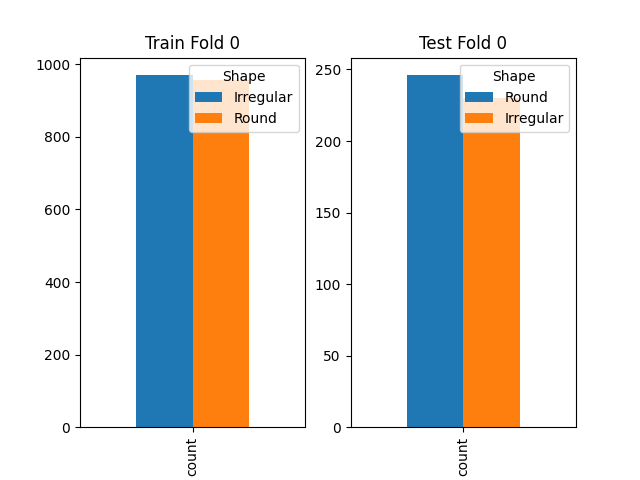

Shape
Round        1041
Irregular     889
Name: count, dtype: int64
Shape
Round        162
Irregular    162
Name: count, dtype: int64


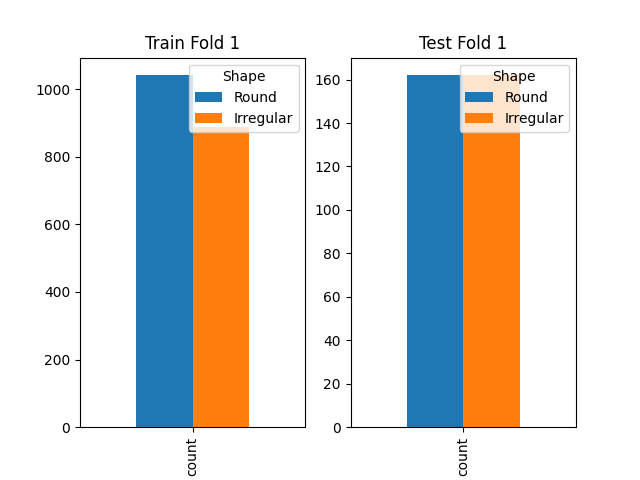

Shape
Round        978
Irregular    953
Name: count, dtype: int64
Shape
Irregular    247
Round        225
Name: count, dtype: int64


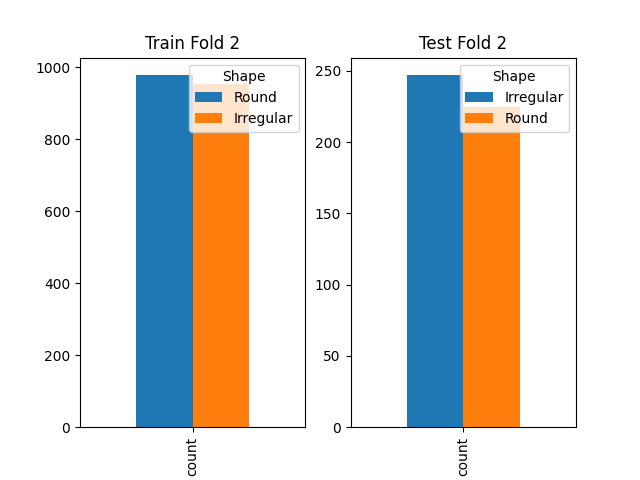

Shape
Round        988
Irregular    979
Name: count, dtype: int64
Shape
Irregular    221
Round        215
Name: count, dtype: int64


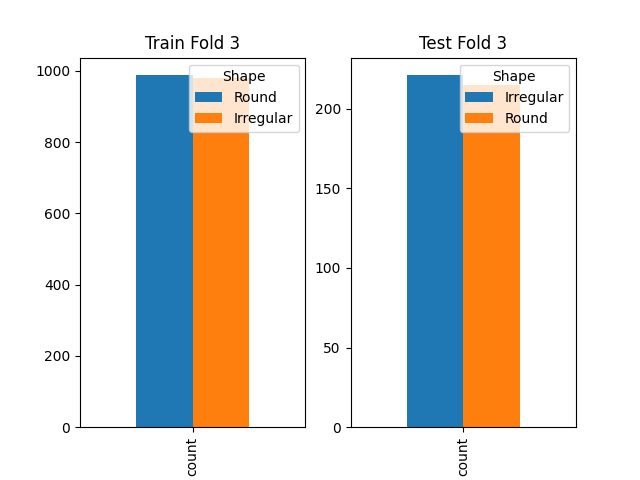

Shape
Irregular    1009
Round         848
Name: count, dtype: int64
Shape
Irregular    191
Round        191
Name: count, dtype: int64


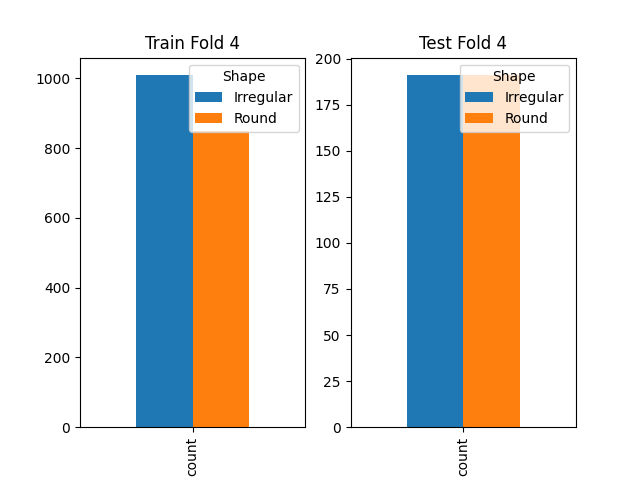

In [17]:
train_folds_index = []
test_folds_index = []
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    ind_lists_train = [list(serie[serie==k].index[:].ravel()) for k in X[train_index]]
    flat_list_train = [
        x
        for xs in ind_lists_train
        for x in xs
        ]
    train_folds_index.append(flat_list_train)
    ind_lists_test = [list(serie[serie==k].index[:].ravel()) for k in X[test_index]]
    flat_list_test = [
        x
        for xs in ind_lists_test
        for x in xs
    ]
    
    a_train = data_without_amb.iloc[flat_list_train]['Shape'].value_counts().min()
    b_train = data_without_amb.iloc[flat_list_train]['Shape'].value_counts().max()
    
    a_test = data_without_amb.iloc[flat_list_test]['Shape'].value_counts().min()
    b_test = data_without_amb.iloc[flat_list_test]['Shape'].value_counts().max()
    
    if a_test/(a_test + b_test) < 0.4:
        label_maj = data_without_amb.iloc[flat_list_test]['Shape'].value_counts().idxmax()
        label_min = data_without_amb.iloc[flat_list_test]['Shape'].value_counts().idxmin()
        df_majority = data_without_amb.iloc[flat_list_test]['Shape'].loc[data_without_amb.iloc[flat_list_test]['Shape']==label_maj]
        df_majority_downsampled = resample(df_majority, replace=False, n_samples=a_test, random_state=125)
        
        index_list = data_without_amb.iloc[flat_list_test].loc[data_without_amb.iloc[flat_list_test]['Shape']==label_min].index
        row_numbers_min = [data_without_amb.index.get_loc(idx) for idx in index_list]
        
        flat_list_test = row_numbers_min + [data_without_amb.index.get_loc(idx) for idx in df_majority_downsampled.index]
    test_folds_index.append(flat_list_test)
    
    print(data_without_amb.iloc[flat_list_train]['Shape'].value_counts())
    print(data_without_amb.iloc[flat_list_test]['Shape'].value_counts())
    data_train = pd.DataFrame(data_without_amb.iloc[flat_list_train]['Shape'].value_counts())
    data_test = pd.DataFrame(data_without_amb.iloc[flat_list_test]['Shape'].value_counts())
    _, axs = plt.subplots(1, 2)
    data_train.T.plot.bar(title=f'Train Fold {str(i)}', ax=axs[0])
    data_test.T.plot.bar(title=f'Test Fold {str(i)}', ax=axs[1])
    
    plt.show()
    

In [18]:
class ToTensor(object):

    def __call__(self, sample):
        image, shape = sample['image'], sample['shape']
        if shape=='Round':
            shape=0
        elif shape=='Irregular':
            shape=1
        elif shape=='Ambiguous':
            shape=2
        return {'image': torch.from_numpy(image).unsqueeze(0),
                'shape': torch.from_numpy(np.asarray(shape))}

In [19]:
class RandAugmentTransforms(object):
    def __init__(self, nb_transf, magnitude):
        self.nb_transf = nb_transf
        self.magnitude = magnitude
    def __call__(self, sample):
        image, shape = sample['image'], sample['shape']
        transf = transforms.RandAugment(num_ops=self.nb_transf, magnitude=self.magnitude)
        return {'image': np.array(transf(image)),
                'shape': shape}

In [20]:
class ToPIL(object):
    def __call__(self, sample):
        image, shape = sample['image'], sample['shape']
        transf = transforms.ToPILImage()
        return {'image': transf(image),
                'shape': shape}

In [21]:
class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, sample):
        image, shape = sample['image'], sample['shape']
        norm = transforms.Normalize(mean=self.mean, std=self.std)
        return {'image': norm(image.float()),
                'shape': shape}

In [22]:
def get_mean_std(loader):
    # Compute the mean and standard deviation of all pixels in the dataset
    num_data = 0
    mean = 0.0
    std = 0.0
    for images in loader:
        batch_size, num_channels, height, width = images['image'].shape
        num_data += 1#batch_size * height * width

        mean += images['image'].float().mean(axis=(0, 2, 3))
        std += images['image'].float().std(axis=(0, 2, 3))
    mean /= num_data
    std /= num_data

    return mean, std

In [23]:
transformed_dataset = AxialCutsDataset(data_shape=data, downsample=True, transform= ToTensor())

In [24]:
for i, sample in enumerate(transformed_dataset):
    print(i, sample['image'].size(), sample['shape'])

    if i == 3:
        break

0 torch.Size([1, 51, 51]) tensor(2)
1 torch.Size([1, 51, 51]) tensor(2)
2 torch.Size([1, 51, 51]) tensor(2)
3 torch.Size([1, 51, 51]) tensor(2)


0 torch.Size([4, 1, 51, 51]) torch.Size([4])
1 torch.Size([4, 1, 51, 51]) torch.Size([4])
2 torch.Size([4, 1, 51, 51]) torch.Size([4])
3 torch.Size([4, 1, 51, 51]) torch.Size([4])
tensor([1, 2, 2, 2])


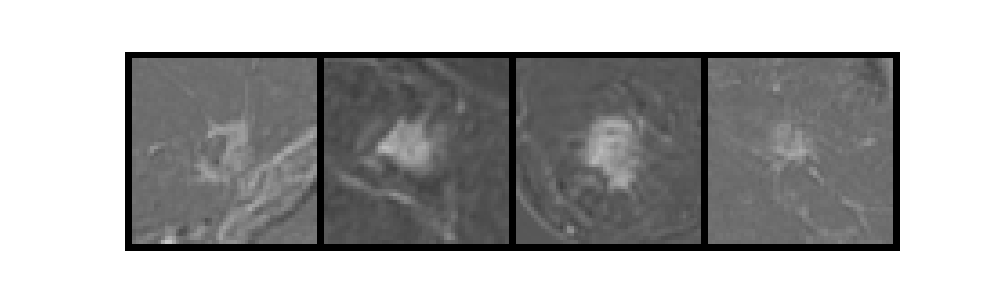

In [25]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=0)
for i_batch, sample_batched in enumerate(dataloader):

    print(i_batch, sample_batched['image'].size(), sample_batched['shape'].size())
    if i_batch == 3:
        
        plt.figure(figsize=(10, 3))
        images_batch, label_batch = sample_batched['image'], sample_batched['shape']
        print(label_batch)
        batch_size = len(images_batch)
        im_size = images_batch.size(2)
        grid_border_size = 2
        grid = utils.make_grid(images_batch)

        plt.imshow(grid.numpy().transpose((1, 2, 0)))
        plt.axis('off')
        plt.ioff()
        
        plt.show()
        break

In [26]:
normalized_datasets = []
means = []
stds = []
for fold in range(0, 5):
    
    train_sampler = torch.utils.data.SubsetRandomSampler(train_folds_index[fold])
    test_sampler = torch.utils.data.SubsetRandomSampler(test_folds_index[fold])
    
    new_dataloader = DataLoader(transformed_dataset, batch_size=1, num_workers=7, sampler=train_sampler)
    a=[k['image'] for k in new_dataloader]
    mean = np.mean(a)
    std = np.std(a)
    print(mean)
    print(std)
    means.append(mean)
    stds.append(std)
    data_transforms = transforms.Compose([
        ToPIL(),
        RandAugmentTransforms(nb_transf=2, magnitude=9),
        ToTensor(),
        Normalize(mean=mean, std=std)
    ])
    normalized_dataset = AxialCutsDataset(data_shape=data_without_amb, downsample=True, transform=data_transforms)
    normalized_datasets.append(normalized_dataset)
    if fold == 0:
        normalized_dataset_for_viz = AxialCutsDataset(data_shape=data, downsample=True, transform=data_transforms)

87.71388394587767
29.847407867319877
87.23479450908678
29.716897991008246
87.70675740976014
29.90188936310633
87.23883368154323
29.850835629668207
87.21365524257789
29.79537411562899


In [27]:
print(np.mean(means))

87.42158495776914


In [28]:
print(np.mean(stds))

29.822480993346336


In [29]:
df = pd.DataFrame(normalized_dataset_for_viz.data)

In [30]:
round_index = np.where(df['Shape']=='Round')[0]
irregular_index = np.where(df['Shape']=='Irregular')[0]
ambiguous_index = np.where(df['Shape']=='Ambiguous')[0]

In [31]:
round_subsample = torch.utils.data.SubsetRandomSampler(round_index)
irregular_subsample = torch.utils.data.SubsetRandomSampler(irregular_index)
ambiguous_subsample = torch.utils.data.SubsetRandomSampler(ambiguous_index)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


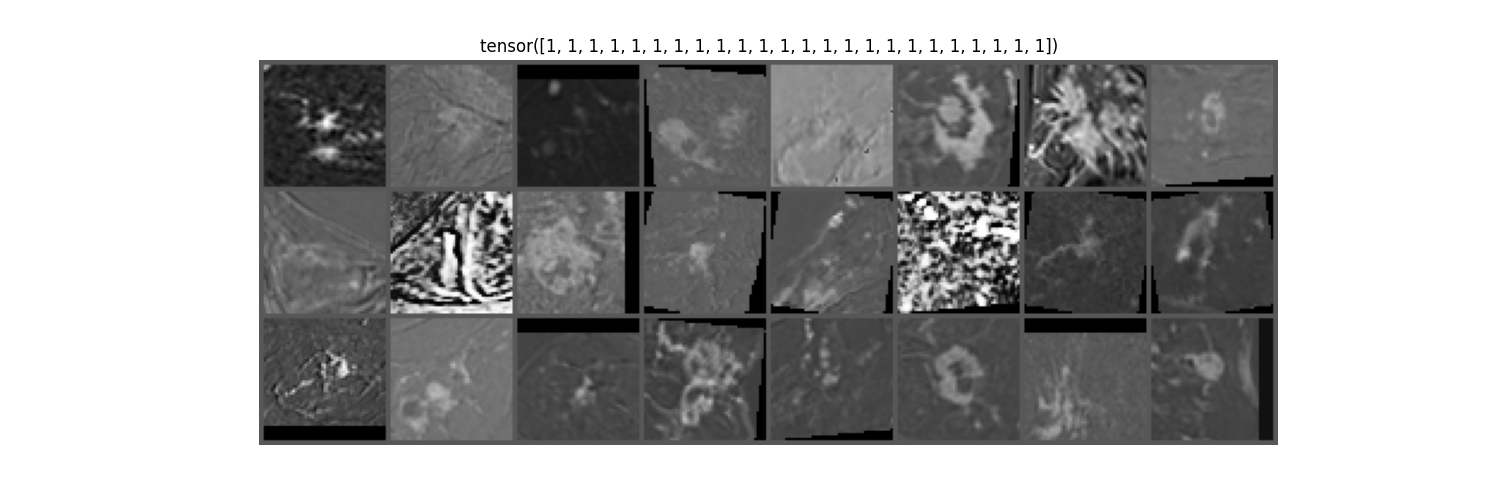

In [32]:
plt.close('all')
vizloader = DataLoader(normalized_dataset_for_viz, batch_size=24, num_workers=0, sampler=irregular_subsample)
minim = min(
    torch.min(normalized_dataset_for_viz[k]['image'])
    for k in range(len(vizloader))
)
maxim = max(
    torch.max(normalized_dataset_for_viz[k]['image'])
    for k in range(len(vizloader))
)
for i_batch, sample_batched in enumerate(vizloader):
    if i_batch == 23:

        plt.figure(figsize=(15, 5))
        images_batch, label_batch = sample_batched['image'], sample_batched['shape']
        print(label_batch)
        batch_size = len(images_batch)

        grid = utils.make_grid(images_batch)

        plt.imshow(((grid.numpy().transpose((1, 2, 0)) - minim.numpy()) / (maxim-minim)), vmin=0, vmax=1)
        plt.title(label_batch)
        plt.axis('off')
        plt.ioff()

        plt.show()
        break

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


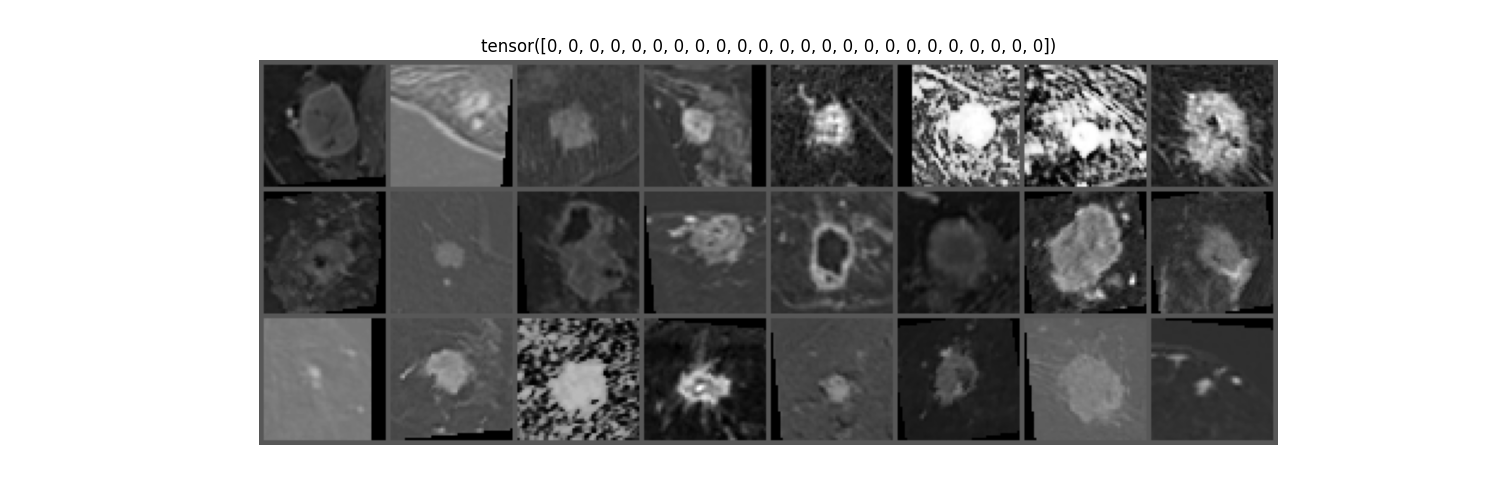

In [33]:
plt.close('all')
vizloader = DataLoader(normalized_dataset_for_viz, batch_size=24, num_workers=0, sampler=round_subsample)
minim = min(
    torch.min(normalized_dataset_for_viz[k]['image'])
    for k in range(len(vizloader))
)
maxim = max(
    torch.max(normalized_dataset_for_viz[k]['image'])
    for k in range(len(vizloader))
)
for i_batch, sample_batched in enumerate(vizloader):
    if i_batch == 23:
        
        plt.figure(figsize=(15, 5))
        images_batch, label_batch = sample_batched['image'], sample_batched['shape']
        print(label_batch)
        batch_size = len(images_batch)
        im_size = images_batch.size(2)
        grid_border_size = 2
        
        grid = utils.make_grid(images_batch)

        plt.imshow(((grid.numpy().transpose((1, 2, 0)) - minim.numpy()) / (maxim-minim)), vmin=0, vmax=1)
        plt.title(label_batch)
        plt.axis('off')
        plt.ioff()
        
        plt.show()
        break

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])


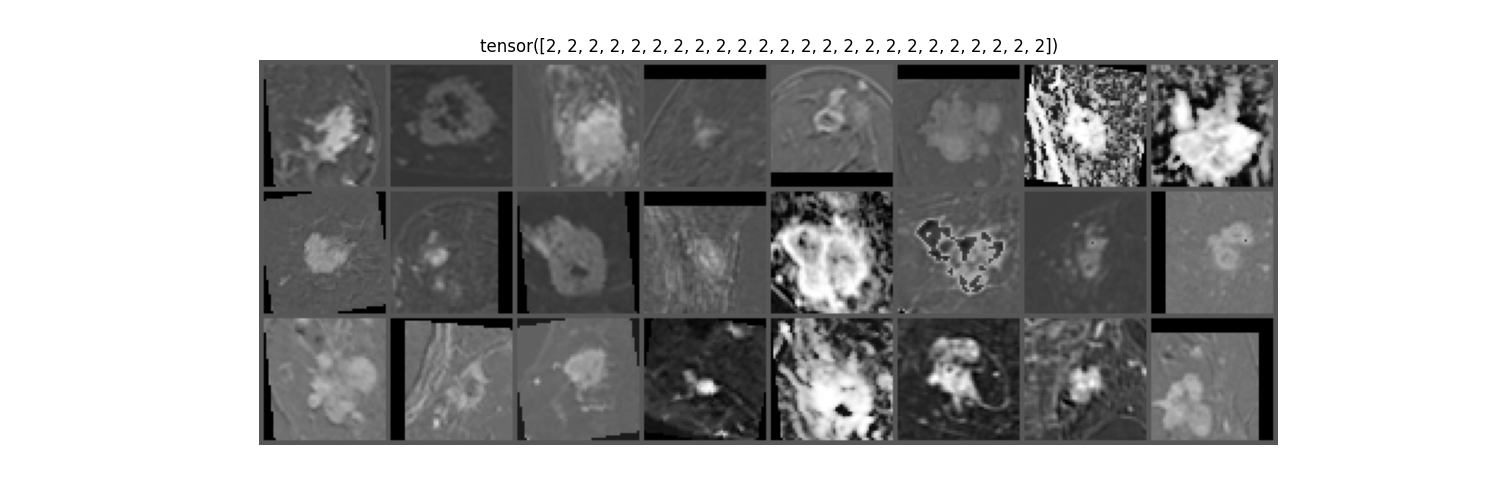

In [34]:
plt.close('all')
vizloader = DataLoader(normalized_dataset_for_viz, batch_size=24, num_workers=0, sampler=ambiguous_subsample)
minim = min(
    torch.min(normalized_dataset_for_viz[k]['image'])
    for k in range(len(vizloader))
)
maxim = max(
    torch.max(normalized_dataset_for_viz[k]['image'])
    for k in range(len(vizloader))
)
for i_batch, sample_batched in enumerate(vizloader):
    if i_batch == 23:
        
        plt.figure(figsize=(15, 5))
        images_batch, label_batch = sample_batched['image'], sample_batched['shape']
        print(label_batch)
        batch_size = len(images_batch)
        im_size = images_batch.size(2)
        grid_border_size = 2
        
        grid = utils.make_grid(images_batch)

        plt.imshow(((grid.numpy().transpose((1, 2, 0)) - minim.numpy()) / (maxim-minim)), vmin=0, vmax=1)
        plt.title(label_batch)
        plt.axis('off')
        plt.ioff()
        
        plt.show()
        break

In [35]:
# Define your CNN model
class simpleNet(nn.Module):
    def __init__(self):
        super(simpleNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout_conv = nn.Dropout(0.3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*12*12, 64)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x= self.dropout_conv(x)
        x = self.pool(self.relu(self.conv2(x)))
        x = self.dropout_conv(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [36]:
# Initialize weights
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [37]:
# Define functions for evaluation metrics
def accuracy(outputs, labels):
    preds = outputs > 0.5 
    return accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

def f1(outputs, labels):
    preds = outputs > 0.5
    return f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average='binary')

def calculate_sensitivity(outputs, labels):
    preds = outputs > 0.5
    return recall_score(labels.cpu().numpy(), preds.cpu().numpy(), average='binary')

def roc_auc(outputs, labels):
    probs = outputs.cpu().detach().numpy()
    return roc_auc_score(labels.cpu().numpy(), probs)

def compute_confusion_matrix(outputs, labels):
    preds = outputs > 0.5
    return confusion_matrix(labels.cpu().numpy(), preds.cpu().numpy())

def calculate_specificity(cm):
    TN = cm[0, 0]  # True negatives
    FP = cm[0, 1]  # False positives
    return TN / (TN + FP)

In [38]:
def display_results_1fold(n_epochs, results):
    
    epochs = range(1, n_epochs + 1)

    _, axs = plt.subplots(2, 1, sharex= True, figsize=(7, 10))
    for key, item in results.items():
        if 'losses' not in key and 'confusion' not in key:
            _plot_per_epoch(epochs, item, key, axs[0])

    _extracted_from_display_results_10('Metrics', 'Validation Metrics', axs[0])
    
    # Plotting the losses
    for key, item in results.items():
        if 'losses' in key:
            _plot_per_epoch(epochs, item, key, axs[1])
    _extracted_from_display_results_10('Loss', 'Training and Validation Loss', axs[1])
    plt.show()


# TODO Rename this here and in `display_results`
def _extracted_from_display_results_10(arg0, arg1, ax):
    ax.set_xlabel('Epochs')
    ax.set_ylabel(arg0)
    ax.set_title(arg1)
    ax.legend()
    
def _plot_per_epoch(epochs, res, label, ax):
    ax.plot(epochs, res, label=label)

In [39]:
def training(x, optim, model, crit, train_loss):
    data = x['image']
    target = x['shape']
    # move tensors to GPU if CUDA is available
    if torch.cuda.is_available():
        data, target = data.to(device), target.to(device)
    # clear the gradients of all optimized variables
    optim.zero_grad()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = crit(output, target.float().view(-1, 1))
    # backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()
    # perform a single optimization step (parameter update)
    optim.step()

    # update training loss
    train_loss += loss.item()
    
    return train_loss, optim

In [40]:
def testing(x, model, crit, valid_loss, all_preds, all_labels):
    data = x['image']
    target = x['shape']
    if torch.cuda.is_available():
        data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = crit(output, target.float().view(-1, 1))
    # update average validation loss 
    valid_loss += loss.item()

    # Accumulate predictions and labels
    all_preds.append(output.cpu().detach().numpy())
    all_labels.append(target.cpu().detach().numpy())
    
    return valid_loss

In [41]:
def append_to_list(list, value):
    list.append(value)

In [42]:
def calculate_val_metrics(epoch, train_size, test_size, train_losses, val_losses, train_loss, valid_loss, all_preds, all_labels, val_accuracies, val_sensitivities, val_specificities, val_roc_aucs, val_cms):
    # calculate average losses
    train_loss = train_loss/train_size
    valid_loss = valid_loss/test_size

    # Concatenate predictions and labels
    all_preds = torch.from_numpy(np.concatenate(all_preds, axis=0))
    all_labels = torch.from_numpy(np.concatenate(all_labels, axis=0))

    # Compute evaluation metrics
    acc = accuracy(all_preds, all_labels)
    f1_result = f1(all_preds, all_labels)
    roc_auc_result = roc_auc(all_preds, all_labels)
    cm = compute_confusion_matrix(all_preds, all_labels)
    sensitivity_value = calculate_sensitivity(all_preds, all_labels)
    specificity_value = calculate_specificity(cm)

    for lists, vals in zip([val_accuracies, val_sensitivities, val_specificities, val_roc_aucs, val_cms, train_losses, val_losses], [acc, sensitivity_value, specificity_value, roc_auc_result, cm, train_loss, valid_loss]):
        append_to_list(lists, vals)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuracy: {:.6f} \tF1 Score: {:.6f} \tROC AUC: {:.6f} \tSpecificity: {:.6f} \tSensitivity: {:.6f}'.format(
        epoch, train_loss, valid_loss, acc, f1_result, roc_auc_result, specificity_value, sensitivity_value))
    
    return train_loss, valid_loss

In [43]:
def save_model(model, path, valid_loss_min, valid_loss):
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min, valid_loss))
    torch.save(model.state_dict(), path)
    valid_loss_min = valid_loss
    
    return valid_loss_min

In [44]:
def train_model(model, train_loader, test_loader, fold_id, n_epochs=15, with_data_aug=False):
    
    plt.close('all')
    model.apply(weights_init)

    # Loss function
    criterion = nn.BCELoss()# Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    train_losses = []
    val_losses = []
    val_accuracies = []
    val_sensitivities = []
    val_specificities = []
    val_roc_aucs = []
    val_cms = []
    valid_loss_min = np.Inf # track change in validation loss
    
    for epoch in range(1, n_epochs+1):

        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        # train the model #
        model.train()
        for x in train_loader:
            train_loss, optimizer = training(x, optimizer, model, criterion, train_loss)

        # Validating the model
        model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for x in test_loader:
                valid_loss = testing(x, model, criterion, valid_loss, all_preds, all_labels)

        train_loss, valid_loss = calculate_val_metrics(epoch, len(train_loader), len(test_loader), train_losses, val_losses, train_loss, valid_loss, all_preds, all_labels, 
                                                       val_accuracies, val_sensitivities, val_specificities, val_roc_aucs, val_cms)        
        
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            if with_data_aug:
                valid_loss_min = save_model(model, f'model_shape_{str(fold_id)}_augmented.pt', valid_loss_min, valid_loss)
            else:
                valid_loss_min = save_model(model, f'model_shape_{str(fold_id)}.pt', valid_loss_min, valid_loss)
        scheduler.step(valid_loss)
    
    return val_accuracies, val_sensitivities, val_specificities, val_roc_aucs, train_losses, val_losses, val_cms


In [45]:
def create_model(device):
    model = simpleNet()
    if torch.cuda.is_available():
        torch.cuda.manual_seed(0)
        torch.cuda.manual_seed_all(0)
        model.to(device)
    
    return model

In [46]:
results = {}
for fold in range(0, 5):
    print(f'Training fold {fold}')
    train_sampler = torch.utils.data.SubsetRandomSampler(train_folds_index[fold])
    test_sampler = torch.utils.data.SubsetRandomSampler(test_folds_index[fold])

    train_loader = torch.utils.data.DataLoader(normalized_datasets[fold], num_workers=12, batch_size=16, sampler=train_sampler)
    test_loader = torch.utils.data.DataLoader(normalized_datasets[fold], num_workers=12, batch_size=16, sampler=test_sampler)

    model = create_model(device)
    val_accuracies, val_sensitivities, val_specificities, val_roc_aucs, train_losses, val_losses, cms = train_model(model, train_loader, test_loader, fold, n_epochs=40, with_data_aug=True)
    fold_results = {
        'accuracies': val_accuracies,
        'sensitivities': val_sensitivities,
        'specificities': val_specificities,
        'aucs': val_roc_aucs,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'confusion_matrix': cms}
    results[f'Fold_{fold}'] = fold_results

Training fold 0


/home/psteinmetz/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch: 1 	Training Loss: 0.697542 	Validation Loss: 0.613741 	Accuracy: 0.670168 	F1 Score: 0.592208 	ROC AUC: 0.758978 	Specificity: 0.833333 	Sensitivity: 0.495652
Validation loss decreased (inf --> 0.613741).  Saving model ...
Epoch: 2 	Training Loss: 0.618698 	Validation Loss: 0.601996 	Accuracy: 0.733193 	F1 Score: 0.740286 	ROC AUC: 0.796377 	Specificity: 0.682927 	Sensitivity: 0.786957
Validation loss decreased (0.613741 --> 0.601996).  Saving model ...
Epoch: 3 	Training Loss: 0.608171 	Validation Loss: 0.599464 	Accuracy: 0.705882 	F1 Score: 0.663462 	ROC AUC: 0.770873 	Specificity: 0.804878 	Sensitivity: 0.600000
Validation loss decreased (0.601996 --> 0.599464).  Saving model ...
Epoch: 4 	Training Loss: 0.569713 	Validation Loss: 0.591578 	Accuracy: 0.712185 	F1 Score: 0.666667 	ROC AUC: 0.778544 	Specificity: 0.821138 	Sensitivity: 0.595652
Validation loss decreased (0.599464 --> 0.591578).  Saving model ...
Epoch: 5 	Training Loss: 0.557811 	Validation Loss: 0.563603 	Acc

/home/psteinmetz/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch: 1 	Training Loss: 0.705867 	Validation Loss: 0.670952 	Accuracy: 0.651235 	F1 Score: 0.542510 	ROC AUC: 0.743446 	Specificity: 0.888889 	Sensitivity: 0.413580
Validation loss decreased (inf --> 0.670952).  Saving model ...
Epoch: 2 	Training Loss: 0.620135 	Validation Loss: 0.626687 	Accuracy: 0.728395 	F1 Score: 0.742690 	ROC AUC: 0.778387 	Specificity: 0.672840 	Sensitivity: 0.783951
Validation loss decreased (0.670952 --> 0.626687).  Saving model ...
Epoch: 3 	Training Loss: 0.590379 	Validation Loss: 0.631284 	Accuracy: 0.632716 	F1 Score: 0.570397 	ROC AUC: 0.697226 	Specificity: 0.777778 	Sensitivity: 0.487654
Epoch: 4 	Training Loss: 0.573884 	Validation Loss: 0.606320 	Accuracy: 0.660494 	F1 Score: 0.580153 	ROC AUC: 0.769090 	Specificity: 0.851852 	Sensitivity: 0.469136
Validation loss decreased (0.626687 --> 0.606320).  Saving model ...
Epoch: 5 	Training Loss: 0.555813 	Validation Loss: 0.545235 	Accuracy: 0.746914 	F1 Score: 0.753012 	ROC AUC: 0.803384 	Specificity: 

/home/psteinmetz/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch: 1 	Training Loss: 0.711533 	Validation Loss: 0.646960 	Accuracy: 0.646186 	F1 Score: 0.679463 	ROC AUC: 0.713378 	Specificity: 0.568889 	Sensitivity: 0.716599
Validation loss decreased (inf --> 0.646960).  Saving model ...
Epoch: 2 	Training Loss: 0.621565 	Validation Loss: 0.609001 	Accuracy: 0.690678 	F1 Score: 0.711462 	ROC AUC: 0.758956 	Specificity: 0.648889 	Sensitivity: 0.728745
Validation loss decreased (0.646960 --> 0.609001).  Saving model ...
Epoch: 3 	Training Loss: 0.614511 	Validation Loss: 0.614257 	Accuracy: 0.701271 	F1 Score: 0.706861 	ROC AUC: 0.748646 	Specificity: 0.715556 	Sensitivity: 0.688259
Epoch: 4 	Training Loss: 0.578698 	Validation Loss: 0.623901 	Accuracy: 0.644068 	F1 Score: 0.603774 	ROC AUC: 0.746091 	Specificity: 0.782222 	Sensitivity: 0.518219
Epoch: 5 	Training Loss: 0.564794 	Validation Loss: 0.566092 	Accuracy: 0.743644 	F1 Score: 0.760396 	ROC AUC: 0.792119 	Specificity: 0.706667 	Sensitivity: 0.777328
Validation loss decreased (0.609001 -

/home/psteinmetz/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch: 1 	Training Loss: 0.676891 	Validation Loss: 0.668051 	Accuracy: 0.594037 	F1 Score: 0.636550 	ROC AUC: 0.614143 	Specificity: 0.483721 	Sensitivity: 0.701357
Validation loss decreased (inf --> 0.668051).  Saving model ...
Epoch: 2 	Training Loss: 0.626180 	Validation Loss: 0.612333 	Accuracy: 0.711009 	F1 Score: 0.755814 	ROC AUC: 0.727097 	Specificity: 0.534884 	Sensitivity: 0.882353
Validation loss decreased (0.668051 --> 0.612333).  Saving model ...
Epoch: 3 	Training Loss: 0.599897 	Validation Loss: 0.627338 	Accuracy: 0.642202 	F1 Score: 0.640553 	ROC AUC: 0.697927 	Specificity: 0.655814 	Sensitivity: 0.628959
Epoch: 4 	Training Loss: 0.566404 	Validation Loss: 0.619060 	Accuracy: 0.642202 	F1 Score: 0.597938 	ROC AUC: 0.736062 	Specificity: 0.762791 	Sensitivity: 0.524887
Epoch: 5 	Training Loss: 0.568644 	Validation Loss: 0.599995 	Accuracy: 0.699541 	F1 Score: 0.739563 	ROC AUC: 0.751805 	Specificity: 0.553488 	Sensitivity: 0.841629
Validation loss decreased (0.612333 -

/home/psteinmetz/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch: 1 	Training Loss: 0.697772 	Validation Loss: 0.646859 	Accuracy: 0.730366 	F1 Score: 0.733850 	ROC AUC: 0.773827 	Specificity: 0.717277 	Sensitivity: 0.743455
Validation loss decreased (inf --> 0.646859).  Saving model ...
Epoch: 2 	Training Loss: 0.636304 	Validation Loss: 0.584640 	Accuracy: 0.756545 	F1 Score: 0.738028 	ROC AUC: 0.831282 	Specificity: 0.827225 	Sensitivity: 0.685864
Validation loss decreased (0.646859 --> 0.584640).  Saving model ...
Epoch: 3 	Training Loss: 0.616448 	Validation Loss: 0.599133 	Accuracy: 0.675393 	F1 Score: 0.655556 	ROC AUC: 0.785094 	Specificity: 0.732984 	Sensitivity: 0.617801
Epoch: 4 	Training Loss: 0.602793 	Validation Loss: 0.586323 	Accuracy: 0.722513 	F1 Score: 0.741463 	ROC AUC: 0.776349 	Specificity: 0.649215 	Sensitivity: 0.795812
Epoch: 5 	Training Loss: 0.581455 	Validation Loss: 0.560391 	Accuracy: 0.798429 	F1 Score: 0.797900 	ROC AUC: 0.836655 	Specificity: 0.801047 	Sensitivity: 0.795812
Validation loss decreased (0.584640 -

In [47]:
def display_results_across_folds(n_epochs, results):
    
    plt.close('all')
    epochs = range(1, n_epochs + 1)

    _, axs = plt.subplots(2, 2, sharex= True, figsize=(15, 10))
    acc = [results[k]['accuracies'] for k in results.keys()]
    sens = [results[k]['sensitivities'] for k in results.keys()]
    spec = [results[k]['specificities'] for k in results.keys()]
    aucs = [results[k]['aucs'] for k in results.keys()]

    _plot_per_epoch(epochs, acc, results.keys(), axs[0, 0])
    _results_disp('Metrics', 'Validation Accuracy', axs[0, 0])
    
    _plot_per_epoch(epochs, sens, results.keys(), axs[0, 1])
    _results_disp('Metrics', 'Validation Sensitivity', axs[0, 1])
    
    _plot_per_epoch(epochs, spec, results.keys(), axs[1, 0])
    _results_disp('Metrics', 'Validation Specificity', axs[1, 0])
    
    _plot_per_epoch(epochs, aucs, results.keys(), axs[1, 1])
    _results_disp('Metrics', 'Validation ROC AUC', axs[1, 1])
    

    plt.show()

def _results_disp(arg0, arg1, ax):
    ax.set_xlabel('Epochs')
    ax.set_ylabel(arg0)
    ax.set_title(arg1)
    ax.legend()
    
def _plot_per_epoch(epochs, res, label, ax):
    for k, lab in zip(res, label):
        ax.plot(epochs, k, label=lab)

In [48]:
def display_losses(n_epochs, results):
    plt.close('all')
    epochs = range(1, n_epochs + 1)
    f, axs = plt.subplots(3, 2, sharex= True, figsize=(15, 10))
    plt.delaxes(axs[2,1])

    # Plotting the losses
    for i, ax in enumerate(axs.flat[:-1]):
        key = f'Fold_{str(i)}'
        _plot_per_epoch(epochs, [results[key]['train_losses'], results[key]['val_losses']], ['Train loss', ['Validation loss']], ax)
        _losses_disp('Loss', f'{key} Training and Validation BCE Loss', ax)
    plt.show()

def _losses_disp(arg0, arg1, ax):
    ax.set_xlabel('Epochs')
    ax.set_ylabel(arg0)
    ax.set_title(arg1)
    ax.legend()
    
def _plot_per_epoch(epochs, res, label, ax):
    for k, lab in zip(res, label):
        ax.plot(epochs, k, label=lab)

In [61]:
def display_confusion_matrix(results):
    plt.close('all')
    _, axs = plt.subplots(2, 3, figsize=(16, 9))
    best_cm = [35, 30, 35, 32, 35]
    plt.delaxes(axs[1,2])
    # Plotting the losses
    for i, (ax, ind) in enumerate(zip(axs.flat[:-1], best_cm)):
        key = f'Fold_{str(i)}'
        _plot_confusion_matrix(results[key]['confusion_matrix'][ind], ['Round', 'Irregular'], ax)
        _conf_matrix_disp(f'{key} Best Confusion Matrix', ax)
    plt.show()

def _conf_matrix_disp(title, ax):
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(title)

def _plot_confusion_matrix(cm, class_names, ax):
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', ax=ax)


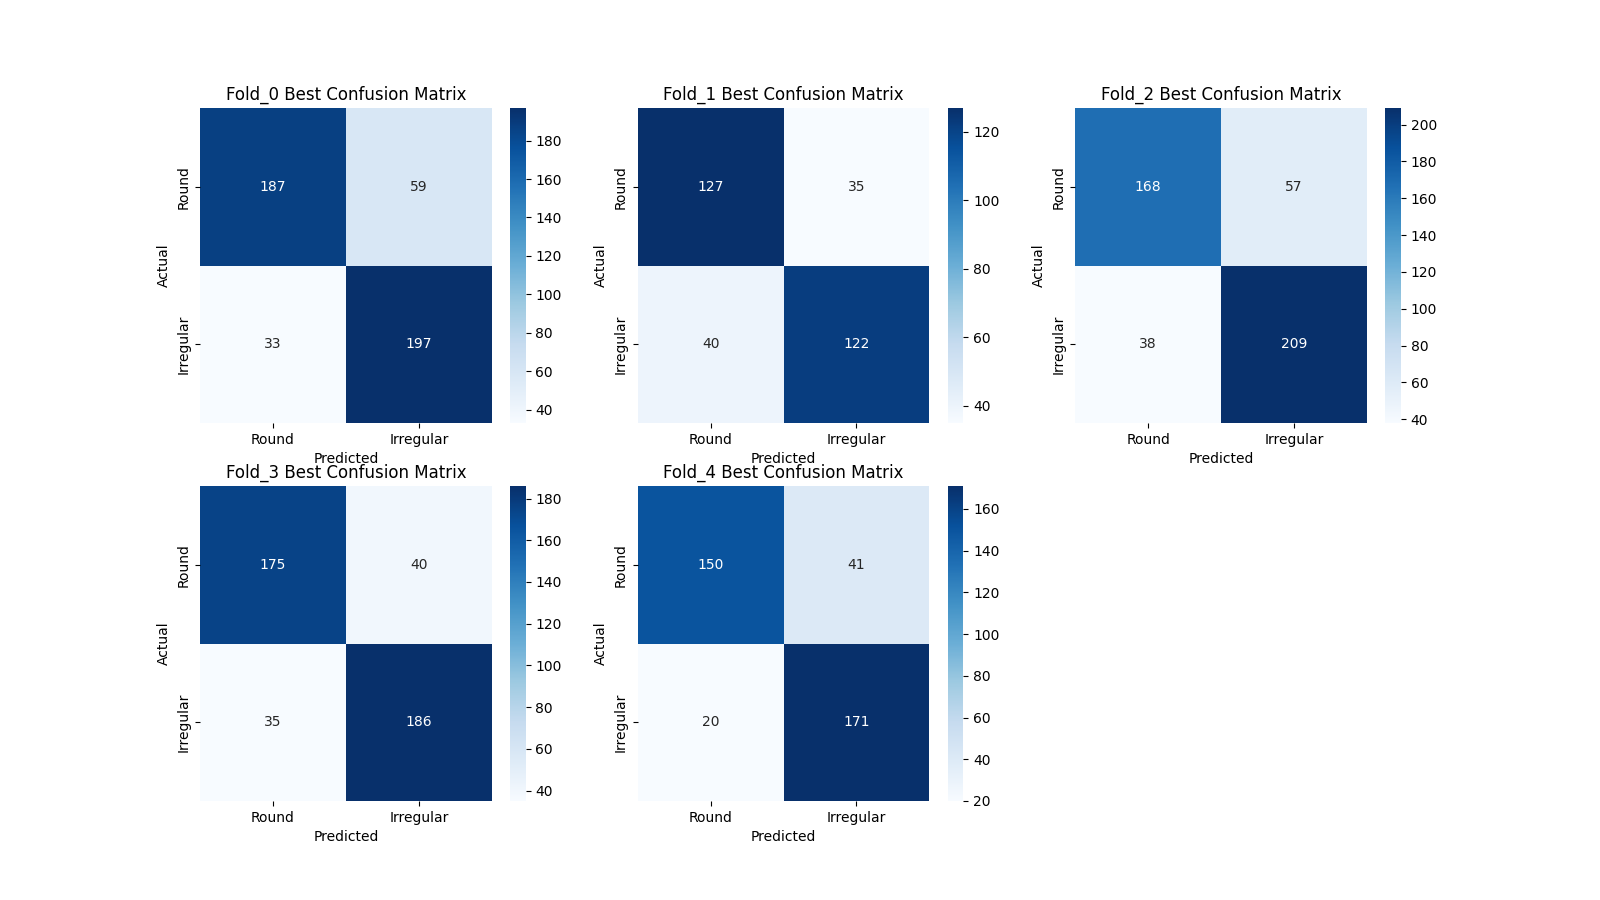

In [62]:
display_confusion_matrix(results)

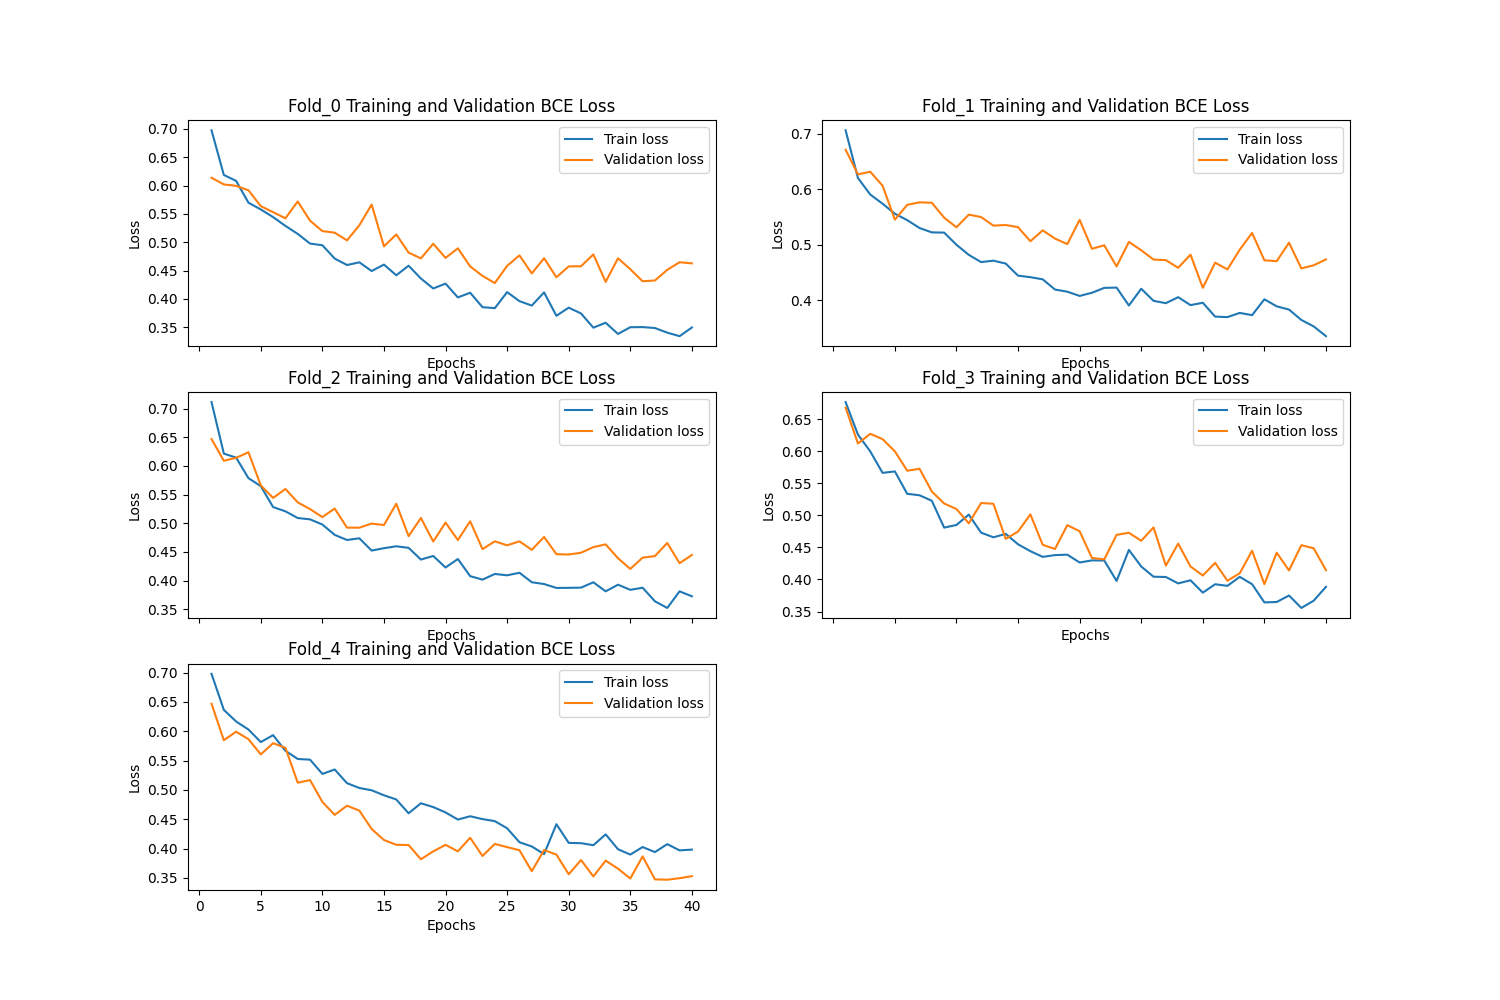

In [51]:
display_losses(40, results)

In [ ]:
results['Fold_4']['specificities'][11]

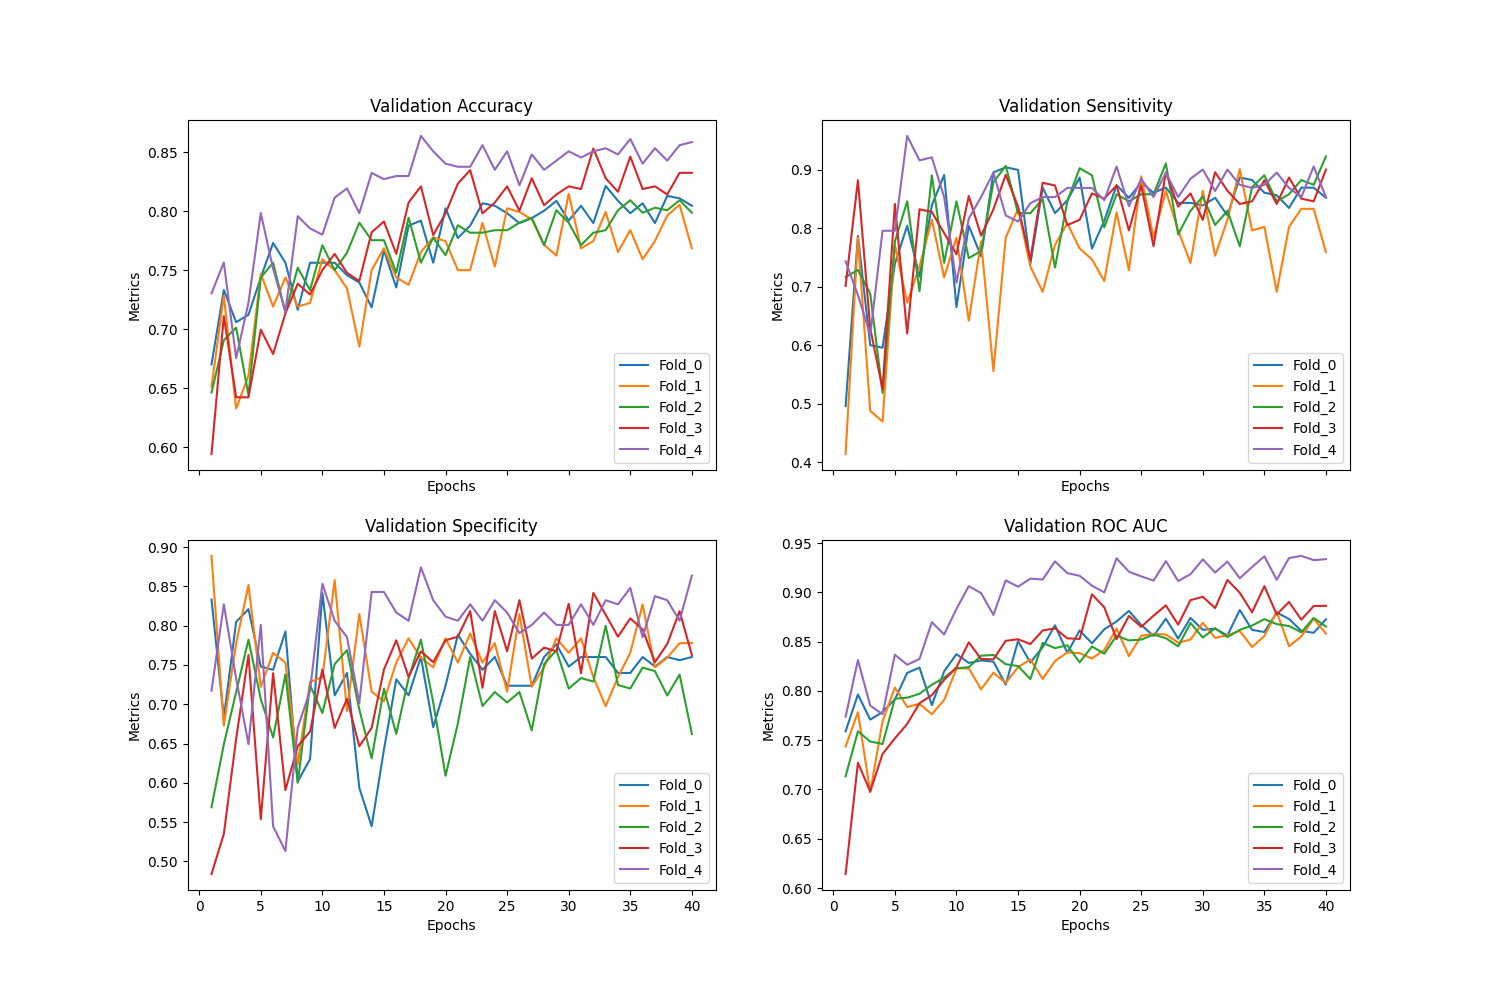

In [54]:
display_results_across_folds(40, results)

In [ ]:
display_results_1fold(15, results['Fold_2'])

In [ ]:
results['Fold_2']